<a href="https://colab.research.google.com/github/andrebelem/pythonverse/blob/main/Trabalhando%20com%20dados%20do%20CHIRPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtendo dados do CHIRPS diário

# Função `get_CHIRPS` 🌧️📊

Esta função foi desenvolvida por **Andre L. Belém** ([@andrebelem](https://www.github.com/andrebelem)) e é utilizada em disciplinas de **Mudanças Climáticas** do **Observatório Oceanográfico da Universidade Federal Fluminense (UFF)** 🌊.

A função tem como objetivo acessar e processar dados de **precipitação diária** a partir da plataforma **CHIRPS** (Climate Hazards Group InfraRed Precipitation with Station data - https://www.chc.ucsb.edu/data/chirps), oferecendo uma maneira simples e automatizada de baixar dados meteorológicos históricos para áreas específicas do globo. Esta funcionalidade é especialmente útil para análises climatológicas, estudos de tendências de precipitação e modelagem ambiental, contribuindo para a compreensão das mudanças climáticas 🌍🔥.

## Principais Funcionalidades 🚀

- **Download de Dados de Precipitação**: A função realiza o download de arquivos de precipitação diária da plataforma CHIRPS, abrangendo um intervalo de datas e uma área geográfica definida pelo usuário (coordenadas e resolução).
- **Exibição de Barra de Progresso**: Utilizando a biblioteca `tqdm`, a função exibe uma barra de progresso informativa, indicando o tempo decorrido, tempo estimado restante e velocidade de download 📈.
- **Mensagens Bilíngues**: A função suporta mensagens e documentações em português e inglês, permitindo sua utilização por uma base de usuários internacional 🌐.
- **Estimativa de Espaço**: Antes do download, a função calcula uma estimativa do espaço necessário para armazenar os dados, informando o usuário da quantidade aproximada de armazenamento em MB e GB 🗄️.

## Exemplo de Uso 🧑‍💻

Aqui está um exemplo de como usar a função para obter dados de precipitação para a região do Rio de Janeiro entre os anos de 1981 e 1991:

```python
get_CHIRPS(
    start_date="1981-01-01",
    end_date="1981-12-31",
    lon_min=-43.5,
    lon_max=-42.5,
    lat_min=-23.1,
    lat_max=-22.7,
    resolution=0.05,
    language="pt"  # Altere para "en" para mensagens em inglês
)


Primeiro, precisamos instalar algumas bibliotecas...

In [36]:
%%capture
!pip install rioxarray
!pip install cartopy


Aqui que a mágica é feita.

In [61]:
from tqdm import tqdm
import pandas as pd
import requests
import rioxarray  # Import para lidar com arquivos .tif
import gzip
from io import BytesIO
import tempfile
import os
import xarray as xr
import numpy as np
import shutil  # Import para excluir o diretório temporário

def estimate_disk_space(start_date, end_date, resolution=0.05, language="pt"):
    """Estima o espaço em disco necessário com base no número de dias e resolução."""
    num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    file_size_kb = 3000 if resolution == 0.05 else 200  # Tamanho aproximado em KB por dia
    total_size_kb = num_days * file_size_kb
    total_size_mb = total_size_kb / 1024
    total_size_gb = total_size_mb / 1024
    print(f"Estimativa de espaço necessário: {total_size_mb:.2f} MB ({total_size_gb:.2f} GB)")

    # Aviso se o tamanho estimado exceder 3 GB, ajustado pelo idioma
    if total_size_gb > 3:
        if language == "pt":
            print("⚠️ Aviso: A estimativa de tamanho de dados excede 3 GB. Isso pode facilmente estourar a capacidade de memória da sua máquina.")
        else:
            print("⚠️ Warning: Estimated data size exceeds 3 GB. This may easily exceed your machine's memory capacity.")

    return total_size_mb, total_size_gb

def get_CHIRPS(start_date, end_date, lon_min, lon_max, lat_min, lat_max, resolution=0.05, language="pt"):
    """
    Obtém dados de precipitação diária do CHIRPS para o intervalo especificado e as coordenadas.
    Processa e salva os dados em arquivos temporários para evitar sobrecarga de memória.

    Parâmetros:
    - start_date, end_date: Datas de início e fim no formato 'YYYY-MM-DD'
    - lon_min, lon_max, lat_min, lat_max: Coordenadas da área de interesse
    - resolution: Resolução dos dados (0.05 graus ou 0.25 graus)
    - language: Idioma para exibição das mensagens e da documentação ('pt' para português, 'en' para inglês)

    Retorna:
    - Um xarray.Dataset consolidado com os dados diários de precipitação no intervalo e área especificados.
    """
    # Estima o espaço necessário em disco
    estimate_disk_space(start_date, end_date, resolution, language)

    # Define o caminho de resolução com base no parâmetro resolution
    res_path = "p05" if resolution == 0.05 else "p25"

    # URL base do servidor CHIRPS, ajustada com a resolução
    base_url = f"https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/{res_path}"
    date_range = pd.date_range(start=start_date, end=end_date)

    # Cria um diretório temporário para armazenar os arquivos .nc
    temp_dir = tempfile.mkdtemp()
    if language == "pt":
        print(f"Salvando arquivos temporários em: {temp_dir}")
    else:
        print(f"Saving temporary files in: {temp_dir}")

    with tqdm(total=len(date_range), desc="Baixando e processando dados diários" if language == "pt" else "Downloading and processing daily data", unit="dia" if language == "pt" else "day") as pbar:
        for date in date_range:
            year = date.year
            month = date.strftime("%m")
            day = date.strftime("%d")

            # Monta a URL para o arquivo de cada dia
            url = f"{base_url}/{year}/chirps-v2.0.{year}.{month}.{day}.tif.gz"

            try:
                # Tenta fazer o download do arquivo
                response = requests.get(url, stream=True)

                # Verifica se o download foi bem-sucedido
                if response.status_code == 200:
                    try:
                        # Abre o conteúdo usando gzip e rioxarray para ler o .tif como DataArray
                        with gzip.GzipFile(fileobj=BytesIO(response.content)) as file:
                            da = rioxarray.open_rasterio(file)
                            da = da.sel(x=slice(lon_min, lon_max), y=slice(lat_max, lat_min))

                            # Aplica NaN para valores de precipitação < 0 ou > 1000
                            da = da.where((da >= 0) & (da <= 1000), np.nan)

                            # Converte o DataArray para Dataset e renomeia a variável para 'precip'
                            ds = da.to_dataset(name="precip")

                            # Remove a dimensão 'band' se existir
                            ds = ds.squeeze("band", drop=True) if "band" in ds.dims else ds

                            # Renomeia as coordenadas x e y para lon e lat
                            ds = ds.rename({"x": "lon", "y": "lat"})

                            # Remove a coordenada 'spatial_ref' se existir
                            if "spatial_ref" in ds.coords:
                                ds = ds.drop_vars("spatial_ref")

                            # Adiciona a dimensão de tempo
                            ds = ds.expand_dims(time=[date])

                            # Salva o dataset como um arquivo .nc individual no diretório temporário
                            temp_file_path = os.path.join(temp_dir, f"precip_{date.strftime('%Y%m%d')}.nc")
                            ds.to_netcdf(temp_file_path)

                    except Exception as e:
                        if language == "pt":
                            print(f"Erro ao processar o arquivo para {date}: {e}")
                        else:
                            print(f"Error processing file for {date}: {e}")
                else:
                    if language == "pt":
                        print(f"Arquivo não encontrado para {date} (status: {response.status_code}) - URL: {url}")
                    else:
                        print(f"File not found for {date} (status: {response.status_code}) - URL: {url}")

            except Exception as e:
                if language == "pt":
                    print(f"Erro ao processar dados para {date}: {e}")
                else:
                    print(f"Error processing data for {date}: {e}")

            # Atualiza a barra de progresso
            pbar.update(1)

    # Concatena todos os arquivos .nc em um único Dataset usando open_mfdataset
    try:
        precip_dataset = xr.open_mfdataset(os.path.join(temp_dir, "precip_*.nc"), combine="by_coords")

        # Salva em um único arquivo .nc
        file_path = "precip.nc"
        precip_dataset.to_netcdf(file_path)
        precip_dataset.close()  # Fecha o Dataset para liberar memória
        if language == "pt":
            print("Arquivo precip.nc salvo e fechado com sucesso.")
        else:
            print("File precip.nc saved and closed successfully.")

        # Remove o diretório temporário e seus arquivos
        shutil.rmtree(temp_dir)
        if language == "pt":
            print("Conteúdo do diretório temporário excluído.")
        else:
            print("Temporary directory content deleted.")

        # Reabre o arquivo salvo como um Dataset para retorno
        precip_reloaded = xr.open_dataset(file_path)
        return precip_reloaded
    except Exception as e:
        if language == "pt":
            print(f"Erro ao combinar arquivos .nc: {e}")
        else:
            print(f"Error combining .nc files: {e}")

        # Remove o diretório temporário mesmo em caso de erro
        shutil.rmtree(temp_dir)
        return None



Vamos fazer um pequeno exemplo para a área do Rio de Janeiro.

In [62]:
start_date = "1981-01-01"
end_date = "1981-12-31"
lon_min = -44
lon_max = -42
lat_min = -23.5
lat_max = -22.5

# Chama a função com os parâmetros definidos
precip_rj = get_CHIRPS(start_date, end_date, lon_min, lon_max, lat_min, lat_max, resolution=0.05)



Estimativa de espaço necessário: 1069.34 MB (1.04 GB)
Salvando arquivos temporários em: /tmp/tmp2cs2az1a


Baixando e processando dados diários: 100%|██████████| 365/365 [05:35<00:00,  1.09dia/s]


Arquivo precip.nc salvo e fechado com sucesso.
Conteúdo do diretório temporário excluído.


In [63]:
# verificando como ficou
precip_rj

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 365, lat: 20, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1981-01-01 1981-01-02 ... 1981-12-31
  * lon      (lon) float64 320B -43.97 -43.92 -43.87 ... -42.12 -42.07 -42.02
  * lat      (lat) float64 160B -22.53 -22.58 -22.63 ... -23.38 -23.43 -23.48
Data variables:
    precip   (time, lat, lon) float32 1MB ...

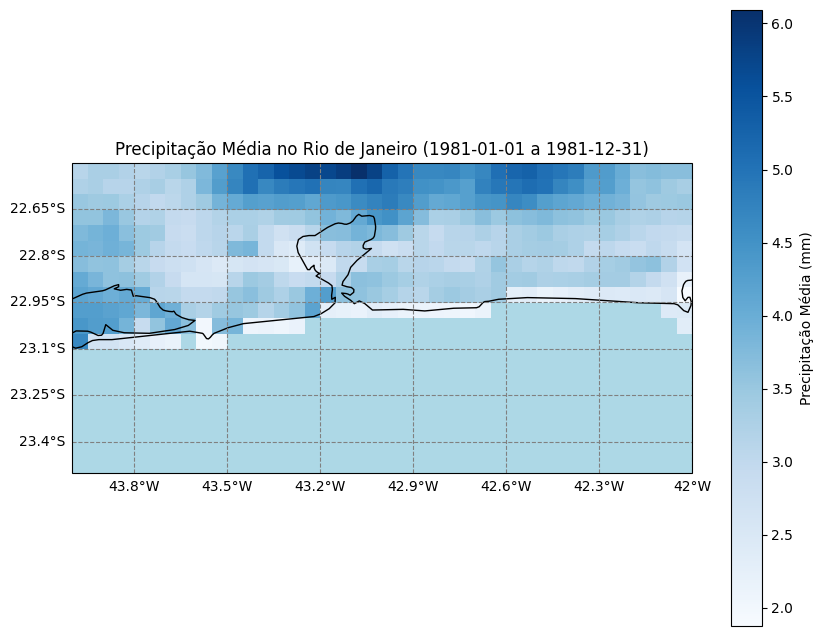

In [65]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Calcula a média da precipitação ao longo do tempo
precip_mean = precip_rj.precip.mean(dim='time')

# Obtém o período de tempo do dataset
start_date = str(precip_rj.time.min().dt.strftime('%Y-%m-%d').values)
end_date = str(precip_rj.time.max().dt.strftime('%Y-%m-%d').values)

# Configura a projeção e o mapa com Cartopy
plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plota o campo de precipitação média com Cartopy
precip_mean.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # Define a transformação de coordenadas
    cmap='Blues',  # Colormap adequado para precipitação
    cbar_kwargs={'label': 'Precipitação Média (mm)'}  # Rótulo da barra de cores
)

# Adiciona elementos do mapa
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Adiciona grades de latitude e longitude
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Define o título com o período de tempo
plt.title(f"Precipitação Média no Rio de Janeiro ({start_date} a {end_date})")
plt.show()




# Conclusão e Próximos Passos 📊

Neste notebook, desenvolvemos uma ferramenta para extrair, processar e visualizar dados de precipitação diária do CHIRPS (Climate Hazards Group InfraRed Precipitation with Station Data) para uma área e período de interesse. Ao longo do processo, implementamos controles para o uso eficiente de memória e espaço em disco, e adaptamos as mensagens do sistema para suporte multilíngue (português e inglês), proporcionando uma experiência personalizada para diferentes públicos.

## Principais Realizações 🌍

- **Download e Processamento dos Dados**: Utilizamos o servidor CHIRPS para extrair dados de precipitação em uma área geográfica especificada e período de tempo, salvando em arquivos temporários para evitar sobrecarga de memória.
- **Média Temporal da Precipitação**: Calculamos a média temporal para obter uma visão geral das condições de precipitação média sobre o período de estudo.
- **Visualização Geoespacial**: Incorporamos `cartopy` para criar mapas georreferenciados dos dados de precipitação média, destacando as áreas com diferentes intensidades de precipitação.

## Próximos Passos 🧭

1. **Análise Espacial e Temporal**: Este dataset permite explorar padrões espaciais e variações sazonais. Investigue a distribuição de precipitação em diferentes épocas do ano e o impacto de eventos climáticos sazonais, como o verão.
2. **Integração com Outros Dados Climáticos**: Para enriquecer sua análise, considere combinar estes dados com informações adicionais, como temperatura, umidade e dados de cobertura do solo. Isso poderá revelar correlações entre precipitação e outros parâmetros ambientais.
3. **Estudos de Mudança Climática**: A série temporal de precipitação pode ser usada para avaliar tendências e variabilidades climáticas ao longo do tempo. Comparar períodos diferentes pode ajudar a identificar sinais de mudanças climáticas e sua intensidade.

## Sugestões para Análises Futuras 📈

- **Análise de Eventos Extremos**: Investigue a frequência e a intensidade dos eventos de precipitação extrema, o que é fundamental para estudos de resiliência climática e gestão de riscos.
- **Modelagem Hidrológica**: Use os dados de precipitação média para alimentar modelos hidrológicos e prever o impacto de chuvas intensas em bacias hidrográficas.
- **Visualizações Avançadas**: Explore diferentes colormaps e projeções para destacar melhor a variabilidade dos dados, e considere criar animações temporais para visualizar a dinâmica da precipitação ao longo do tempo.

## Observações Finais 📝

Os dados de precipitação processados e as ferramentas criadas neste notebook são um ponto de partida valioso para estudos aprofundados sobre variabilidade climática e impacto ambiental. A implementação eficiente e o controle sobre a carga de dados em memória permitem que análises sejam realizadas de maneira prática, mesmo em ambientes de computação limitados.

Sinta-se à vontade para ajustar e expandir este notebook conforme suas necessidades de pesquisa e para compartilhar insights gerados com sua comunidade científica e acadêmica. A análise climática é um campo em constante evolução, e seu trabalho contribui para o entendimento global das mudanças e padrões ambientais.

## Agradecimentos 🙏

Agradecemos ao Climate Hazards Group por disponibilizar os dados CHIRPS que facilitaram o desenvolvimento desta análise.

**Autor:** [Andre L. Belém](https://www.github.com/andrebelem)  
**Projeto:** Observatório Oceanográfico - Universidade Federal Fluminense (UFF)

---

**Bom trabalho e boas análises! 🌊🌧️📊**
